In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
proj_path = "/content/drive/MyDrive/2023/2023_하계_시그널하우스_연구체험 인턴십/01_BIS prediction using EEG signals"

# 전처리

In [ ]:
data0 = np.load(f'{proj_path}/data/raw/0.npy')

print(data0)

[[  nan   nan 16.  ]
 [  nan   nan 16.35]
 [  nan   nan 16.05]
 ...
 [  nan   nan   nan]
 [  nan   nan   nan]
 [  nan   nan   nan]]


In [ ]:
print('shape : ',data0.shape)
print('size : ', data0.size)

shape :  (1963291, 3)
size :  5889873


In [ ]:
np.isnan(data0)[np.isnan(data0) == False].size

2002348

In [ ]:
#BIS nan아닌 애들 indexing

bis = data0[:, 0]
bis_cond = ~np.isnan(bis)

In [ ]:
bis_cond

array([False, False, False, ..., False, False, False])

In [ ]:
idx_arr = np.arange(0, len(bis), 1)
bis_idx = idx_arr[bis_cond]

In [ ]:
bis_idx.shape

(19630,)

In [ ]:
bis_idx

array([     86,     186,     286, ..., 1962890, 1962990, 1963090])

In [ ]:
d = np.isnan(bis_idx)[np.isnan(bis_idx) == True].size
print('bis_label 결측치', d)

bis_label 결측치 0


In [ ]:
#EEG 30s씩 자르기

start = 55*100

eeg_start_idx = bis_idx - start
eeg_start_idx = eeg_start_idx[eeg_start_idx >= 0]

In [ ]:
eeg = data0[:, 2]
eeg

array([16.  , 16.35, 16.05, ...,   nan,   nan,   nan])

In [ ]:
eeg.shape

(1963291,)

In [ ]:
a = np.isnan(bis)[np.isnan(bis) == True].size
b = np.isnan(eeg)[np.isnan(eeg) == True].size

In [ ]:
print( "BIS nan 값 개수 : " , a)
print("EEG nan 값 개수 : " , b)

BIS nan 값 개수 :  1943661
EEG nan 값 개수 :  203


In [ ]:
eeg_start_idx.shape

(19575,)

In [ ]:
eeg_start_idx

array([     86,     186,     286, ..., 1957390, 1957490, 1957590])

In [ ]:
from tqdm import tqdm

In [ ]:
eeg_segments = []
bis_label = []
sqi_label = []
for start_idx in tqdm(eeg_start_idx):
  end_idx = start_idx + 30 * 100
  eeg_segments += list([eeg[start_idx:end_idx]])
  bis_label += list([bis[start_idx]])

100%|██████████| 19575/19575 [00:00<00:00, 240319.58it/s]


In [ ]:
eeg_segments = np.array(eeg_segments)
bis_label = np.array(bis_label)

In [ ]:
eeg_segments

array([[16.3 , 15.85, 15.55, ..., 16.6 , 16.9 , 16.  ],
       [16.25, 16.3 , 16.  , ..., 15.9 , 15.9 , 15.75],
       [15.35, 15.95, 16.3 , ..., 16.05, 15.95, 16.25],
       ...,
       [16.3 , 16.45, 16.15, ..., 16.2 , 16.35, 16.3 ],
       [15.95, 16.1 , 16.1 , ..., 15.85, 16.  , 16.3 ],
       [16.1 , 16.75, 16.45, ..., 16.2 , 16.35, 16.05]])

In [ ]:
bis_label.shape

(19575,)

# 이상치 관련

In [ ]:
from scipy.stats import mode

In [ ]:
#eeg 결측치 채우기

c = np.isnan(eeg_segments)[np.isnan(eeg_segments) == True].size
print('eeg_segments 결측치', c)

eeg_segments 결측치 1890


In [ ]:
#eeg 결측치 채우기

A = eeg_segments

col_mean = np.nanmean(A, axis=1)
print(col_mean)
eeg_segments.shape, col_mean.shape

[16.063      16.06353333 16.06343333 ... 16.16613333 16.1623
 16.16226667]


((19575, 3000), (19575,))

In [ ]:
inds = np.where(np.isnan(A))
A[inds] = np.take(col_mean, inds[1])
print(A)
A.shape


[[16.3  15.85 15.55 ... 16.6  16.9  16.  ]
 [16.25 16.3  16.   ... 15.9  15.9  15.75]
 [15.35 15.95 16.3  ... 16.05 15.95 16.25]
 ...
 [16.3  16.45 16.15 ... 16.2  16.35 16.3 ]
 [15.95 16.1  16.1  ... 15.85 16.   16.3 ]
 [16.1  16.75 16.45 ... 16.2  16.35 16.05]]


(19575, 3000)

In [ ]:
mean = np.mean(A)

std = np.std(A)

print('데이터의 평균은', mean)

print('데이터의 표준 편차는', std)

데이터의 평균은 16.920158993348103
데이터의 표준 편차는 57.83618995961374


In [ ]:
#이상치 제거 사분위수

def outliers_iqr(data):
  q1, q3 = np.percentile(data, [1,99])
  # iqr = q3 - q1
  # lower_bound = q1 - (iqr * 1.5)
  # upper_bound = q3 + (iqr * 1.5)

  # return iqr, lower_bound, upper_bound
  # outlier = np.where((data > upper_bound)|(data < lower_bound))
  # return outlier

  return q1, q3

In [ ]:
# def outliers_1(data):
#   q1, q3 = np.percentile(data, [1,99])

#   return q1, q3
#   # outlier = np.where((data > upper_bound)|(data < lower_bound))
#   # return outlier

In [ ]:
outliers_iqr(A)

(-48.5, 67.2)

In [ ]:
# eeg_del_con_min =  -35.05 < A
# eeg_del_con_max =  A > 70.55

eeg_del_con=  (-48.5 < A) & (A < 67.2)
eeg_del_con.shape
eeg_del_con

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
# false가 하나라도 있는 행 전체를 날려버리기

eeg_false_idx = np.array([np.all(i) for i in eeg_del_con])
eeg_false_idx

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
eeg_selected = A[eeg_false_idx]

In [ ]:
eeg_selected.shape

(1229, 3000)

# outlier 제거 시각화

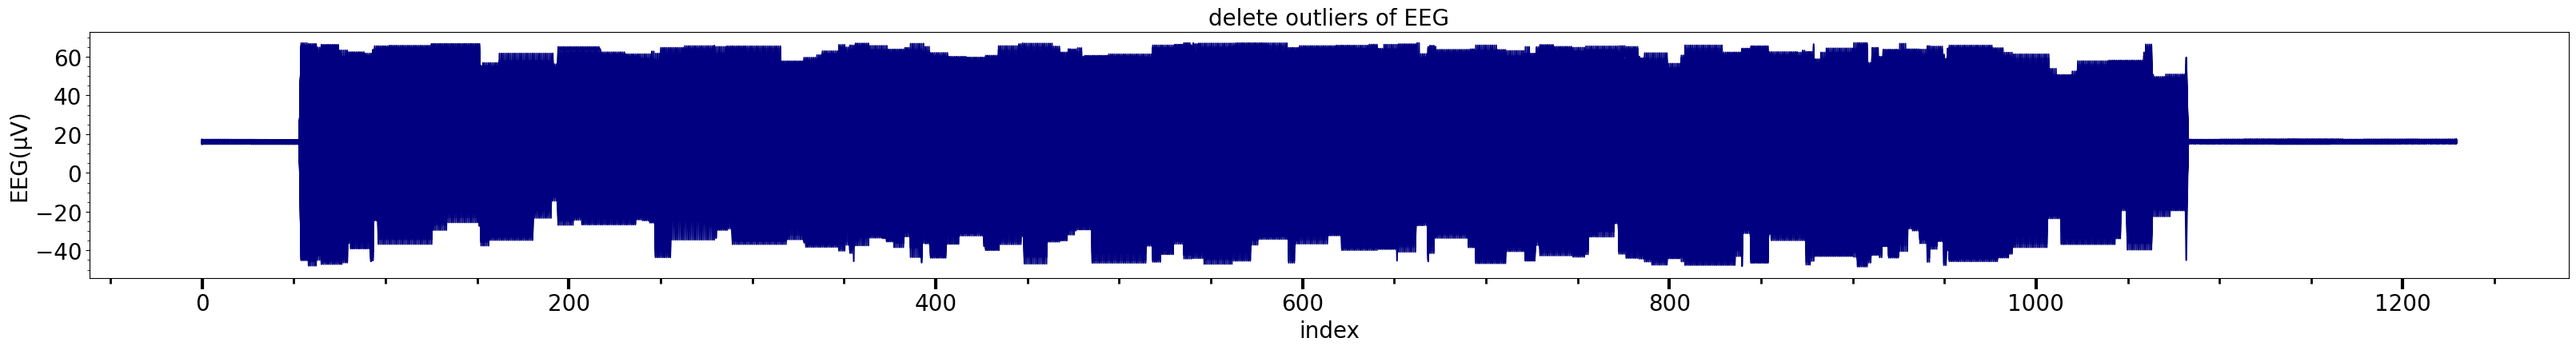

In [ ]:
#시각화

x = np.linspace(0,1229, 1229)
b = eeg_selected
# plt.ticklabel_format(style='plain')

fig, ax = plt.subplots(figsize = (40,4))

plt.plot(x,b, color = 'navy')
plt.xlabel('index', fontsize =20)
plt.ylabel('EEG(μV)', fontsize = 20)
plt.title('delete outliers of EEG', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.ticklabel_format(style='plain')

# ax.set_xticks(minor_xticks, minor=True)
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.xaxis.get_ticklocs(minor=True)

ax.tick_params(axis='x', labelsize=20, length=10, width=3)
ax.tick_params(axis='x', which='minor', length=5, width=2)
# plt.fill_between(x, b, color = 'navy')


In [ ]:
eeg_selected = A[eeg_del_con]

In [ ]:
eeg_selected.shape

(57183435,)

In [ ]:
eeg_sel


In [ ]:
#test

data = [-9,-7,-5,-3,-1,0,1,3,5,7,9]
data = np.array(data)
del_con =  (-7 < data) & (data < 7)
del_con
data = data[del_con]
data


array([-5, -3, -1,  0,  1,  3,  5])